<a href="https://colab.research.google.com/github/wgrgwrght/Simple-Diffusion/blob/main/SimpleDiffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#A Barebones Diffusion Model

"Creating noise from data is easy; creating data from noise is generative modeling." (opening line in [1]). Wouldn't it be great if we could use neural networks to learn the noise in a given sample? This is what diffusion models do!


Imagine a black box that takes in random noise and "generates" samples from an underlying distribution. 

Let's consider a very simple coin toss as a process that generates coin flips with a probability of 0.3 of producing heads. We can describe the underlying probability distribution for this generative process (coin toss) as $p(x)$ where $x\in \{H=1,T=0\}$ is sampled from $p(x)$, i.e., $x\backsim p(x)$. We would like to use a Diffusion Model to model this process using a number of data samples or observations from the original process for training. 

Specifically, we would like to train a generative process such that can generate a series of coin tosses whose probability distribution matches the distribution described above, i.e., $P(H)=0.3, P(T)=0.7$.

In more mathematical terms, we would like to obtain a generative process $x=G(z;\theta)$ that can generate samples $x$ using Normally distributed random input ($z\backsim N(0,1)$) such that the probability distribution of these generated samples $p_G(x)$ is close to $p(x)$ without knowing $p(x)$ in advance or explicitly modelling $p_G(x)$. 

Using a generative diffusion model is an overkill for this simple task and there are much simpler and more effective ways of modelling this simple problem (e.g., inverse sampling: https://en.wikipedia.org/wiki/Inverse_transform_sampling or rejection sampling: https://en.wikipedia.org/wiki/Rejection_sampling). However, this solution is intended to help you understand how Diffusion models can model complex densities implicitly and can be used to generate samples that mimic the true or natural generative process. The bigger goal is cover the mechanics of the diffusion process as well as the intuition behind it. 

We first simulate the coin toss and generate 30,000 training samples below. The histogram shows the (sample estimate of) the true density. 

device cpu


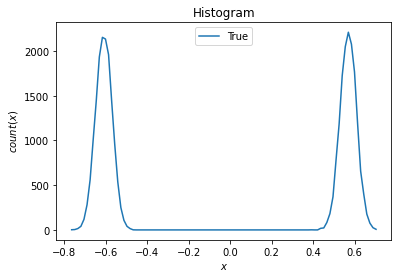

In [63]:
import matplotlib.pyplot as plt
import numpy as np
import torch, torchvision
from torch import nn
from torch.nn import functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device {device}')

# generate samples
small = np.random.normal(loc=50, scale=5.0, size=15000)
large = np.random.normal(loc=200, scale=5.0, size=15000)

# Convert numbers to range 1 - -1 and in correct format for model
large = [[torch.tensor((a/127.5)-1).float()] for a in large]
small = [[torch.tensor((a/127.5)-1).float()] for a in small]
dataset = torch.tensor(large + small)

train_input = dataset.to(device)

#show distribution
hist, bins = np.histogram(dataset, bins=100)
bin_centers = (bins[1:]+bins[:-1])*0.5
plt.plot(bin_centers, hist, label="True")
plt.title('Histogram');plt.xlabel('$x$');plt.ylabel('$count(x)$');plt.legend()
plt.show()

# Forward Process

The goal is to use Normally distributed Random Noise $z\backsim N(0,1)$ as input to generate $x\backsim p(x)$. A diffusion model achieves this by using a fixed "forward process" (not to be confused with the forward function of neural networks) in which we add increasing amounts of random noise to input (training) sample. The forward process is essentially a chain that generates a noisy sample $x_t=q(x_t|x_{t-1})$ by adding noise to the sample $x_{t-1}$ for different time steps $t = 1\ldots T$ with $x_0 = x$ (input sample). Note that the chain is "Markov" as the current step is only dependent upon the previous one (and the added noise). 

As discussed above, the noise is increased over time. The procedure by which the noise is increased is called the schedule. Formally, the forward process can be written as: $q(x_t|x_{t-1})=N(\sqrt{1-\beta_t} x_{t-1},\beta_t I)$ where $\beta_t \in (0,1)$ is the variance of the Gaussian Noise which is increased over time steps. The key assumption is that the noise schedule adds noise to $x$ "slowly" so that  the distribution of the data with the noise at in the beginning is almost the same as the original data distribution, i.e., $(p_{t=1}(x)  \approx p(x))$. However, after "sufficient" time steps, the sample is esssentially isotropic Gaussian noise $(p_{t=T}(x)  \approx N(0,I))$. 

As the noise in each step is Gaussian and it gets summed over time, the overall effect can be modelled as addition of a Gaussian noise (with a variance dependnt upon $t$) to the input sample. As a consequence, we do not need to generate samples in a painstaking step-wise manner. Without worrying about the proof, we can simply say that, we can generate $x_t$ from $x_0$ for any $t$ using the expression below:

$q(x_t|x_0)=N(\sqrt{\hat{\alpha_t}}x_0,(1-\hat{\alpha_t}) I)$

where $\hat{\alpha_t}=\prod_{j=0}^{t}\alpha_t$ and $\alpha_t = 1-\beta_t$. 

Or more simply: 

$x_t = \sqrt{\hat{\alpha_t}}x_0+\sqrt{1-\hat{\alpha_t}}\epsilon$ for $\epsilon\backsim N(0,I)$. 

Thus, the noise added to $x_0$ is simply $\epsilon_t = x_t-x_0 $. 


In [64]:
# precompute values along schedule

T = 50
beta = torch.linspace(1e-4, 0.02, T, device = device)
alpha = 1 - beta
alpha_bar = alpha.log().cumsum(0).exp()
sigma = beta.sqrt()
sqrt_recip_alpha = torch.sqrt(1.0 / alpha)
sqrt_alpha_bar = torch.sqrt(alpha_bar)
sqrt_one_minus_alpha_bar = torch.sqrt(1. - alpha_bar)

In [65]:
""" 
Takes an image and a timestep as input and 

returns the noisy version of it
"""
def forward_diffusion_sample(x_0, t, device="cpu"):

    # define noise to add
    noise = torch.randn_like(x_0)
    
    # add noise to data
    mean = sqrt_alpha_bar[t].to(device) * x_0.to(device)
    variance = sqrt_one_minus_alpha_bar[t].to(device) * noise.to(device)
    
    return mean + variance, noise.to(device)

In [66]:
"""
Image as input

Returns specified number of images showing forward noise diffusion
"""

def show_noise(data, min_num_images):
    # initialise return lists
    timesteps = []
    labels = []
    
    # choose timesteps to record
    stepsize = int(T/(min_num_images-1))
    steps = list(range(0, T, stepsize))
    steps.append(T-1)
    
    for t in steps:
        
        # get noisy version of data and append to list
        data_t, noise = forward_diffusion_sample(data, t, device=device)
        
        #append to list in list format for plotting
        timesteps.append([record[0] for record in data_t.tolist()])
        labels.append(t)
        
    return timesteps, labels


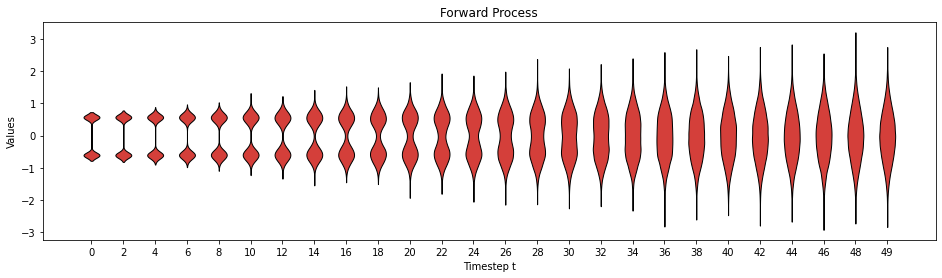

In [67]:
# plot forward process

ts, ls = show_noise(dataset, 20)

fig, ax = plt.subplots(nrows=1, figsize=(16, 4), sharey=True)

parts = ax.violinplot(ts, showmeans=False, showmedians=False, showextrema=False)

for pc in parts['bodies']:
    pc.set_facecolor('#D43F3A')
    pc.set_edgecolor('black')
    pc.set_alpha(1)

ax.set_xticks(np.arange(1, len(ls) + 1))
ax.set_xticklabels(ls)
ax.set_title('Forward Process')
ax.set_ylabel('Values')
ax.set_xlabel('Timestep t')

plt.show()

# Model

In [68]:
# Gets a pair (x, t) and appends t (scalar or 1d tensor) to x as an
# additional dimension / channel

class TimeAppender(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, u):
        x, t = u
        if not torch.is_tensor(t):
            t = x.new_full((x.size(0),), t)
        t = t.view((-1,) + (1,) * (x.dim() - 1)).expand_as(x[:,:1])
        return torch.cat((x, t), 1)

In [69]:
# Define Model

nh = 256

model = nn.Sequential(
    TimeAppender(),
    nn.Linear(train_input.size(1) + 1, nh),
    nn.ReLU(),
    nn.Linear(nh, nh),
    nn.ReLU(),
    nn.Linear(nh, nh),
    nn.ReLU(),
    nn.Linear(nh, train_input.size(1)),
)

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)

model.to(device)

print(f'nb_parameters {sum([ p.numel() for p in model.parameters() ])}')

model.eval()

nb_parameters 132609


Sequential(
  (0): TimeAppender()
  (1): Linear(in_features=2, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=256, bias=True)
  (4): ReLU()
  (5): Linear(in_features=256, out_features=256, bias=True)
  (6): ReLU()
  (7): Linear(in_features=256, out_features=1, bias=True)
)

In [70]:
# train model
epochs = 100
batch_size = 2048

for k in range(epochs):

    epoch_loss = 0

    for x0 in train_input.split(batch_size):
        
        # pick random t
        t = torch.randint(T, (x0.size(0),) + (1,) * (x0.dim() - 1), device = x0.device)
        
        # adds random noise for timestep t
        noise = torch.randn_like(x0)
        xt = torch.sqrt(alpha_bar[t]) * x0 + torch.sqrt(1 - alpha_bar[t]) * noise
        
        # model predicts the noise
        noise_pred = model((xt, t / (T - 1) - 0.5))
        
        # loss function 
        loss = F.mse_loss(noise, noise_pred)
        epoch_loss += loss.item() * x0.size(0)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f'{k} {epoch_loss / train_input.size(0)}')


0 0.9624147981961568
1 0.8546483228047689
2 0.8040174201965332
3 0.767197940826416
4 0.7241458859443665
5 0.700504516061147
6 0.6778233756701152
7 0.6653961577097575
8 0.6386835683186849
9 0.6180143971761067
10 0.6028457683245341
11 0.5991040120442709
12 0.5800101762135823
13 0.5790777922948201
14 0.5680546177864074
15 0.5658074892044067
16 0.5319789062817891
17 0.5360102865854899
18 0.5359722528457641
19 0.5263686505476634
20 0.5079128269513448
21 0.520557525396347
22 0.47857641797065736
23 0.5109611773490905
24 0.48826285347938536
25 0.48648593769073484
26 0.4862122816880544
27 0.49117796489397686
28 0.48993255297342936
29 0.4829415591875712
30 0.47281630902290345
31 0.46619146922429405
32 0.45033024061520893
33 0.4502118364016215
34 0.4470600567817688
35 0.43800659588178
36 0.4617105750242869
37 0.4180440302848816
38 0.44373472232818606
39 0.42644812076886496
40 0.4517581813335419
41 0.4258639693260193
42 0.45429931891759234
43 0.41443758670488995
44 0.440242991733551
45 0.421268321

# Sample Generator

In [71]:
# function to generate a sample from noise

def generate(size, model, min_num_image):

    with torch.no_grad():
        
        ts = []
        ls = []
        
        # start with noise at x_T
        x_T = torch.randn(size, device = device)

        # go through all timesteps t back to x_0
        for t in range(T-1, -1, -1):
            
            # model noise prediction
            output = model((x_T, t / (T - 1) - 0.5))
            
            # formula to get timestep x_(t-1)
            z = torch.zeros_like(x_T) if t == 0 else torch.randn_like(x_T)
            x_T = 1/torch.sqrt(alpha[t]) \
                * (x_T - (1-alpha[t]) / torch.sqrt(1-alpha_bar[t]) * output) \
                + sigma[t] * z
            
            # add first timestep
            if t == (T-1):
                ts.append([a[0] for a in x_T.tolist()])
                ls.append(T-1)
            
            # add to list of timesteps for plotting
            if t % int(T/(min_num_image-1)) == 0:
                ts.append([a[0] for a in x_T.tolist()])
                ls.append(t)

        return x_T, ts, ls

# Reverse Process

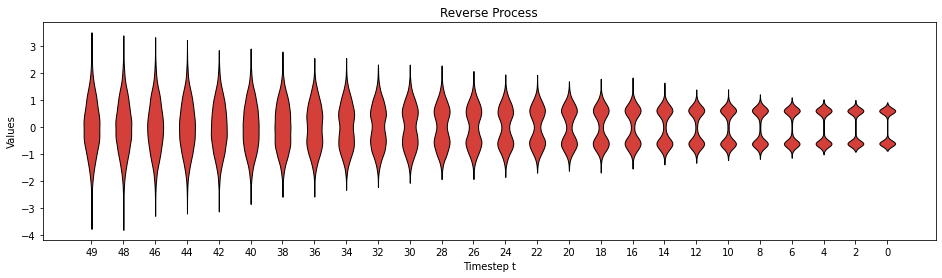

In [72]:
# plot reverse process

x_0, ts, ls = generate((10000, 1), model, 20)

fig, ax = plt.subplots(nrows=1, figsize=(16, 4), sharey=True)

parts = ax.violinplot(ts, showmeans=False, showmedians=False, showextrema=False)

for pc in parts['bodies']:
    pc.set_facecolor('#D43F3A')
    pc.set_edgecolor('black')
    pc.set_alpha(1)

ax.set_xticks(np.arange(1, len(ls) + 1))
ax.set_xticklabels(ls)
ax.set_title('Reverse Process')
ax.set_ylabel('Values')
ax.set_xlabel('Timestep t')

plt.show()

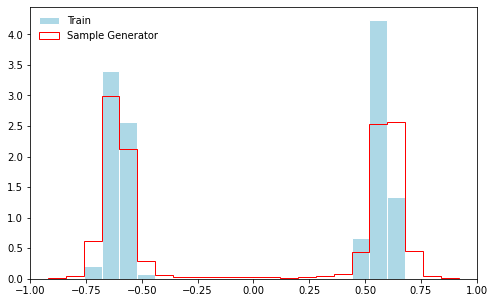

In [73]:
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(8)

ax = fig.add_subplot(1, 1, 1)

x_0, ts, ls = generate((10000, 1), model, 20)

ax.set_xlim(-1.0, 1.0)


d = train_input.flatten().detach().to('cpu').numpy()
ax.hist(d, 25, (-1, 1),
        density = True,
        histtype = 'bar', edgecolor = 'white', color = 'lightblue', label = 'Train')

d = x_0.flatten().detach().to('cpu').numpy()
ax.hist(d, 25, (-1, 1),
        density = True,
        histtype = 'step', color = 'red', label = 'Sample Generator')

ax.legend(frameon = False, loc = 2)

if hasattr(plt.get_current_fig_manager(), 'window'):
    plt.get_current_fig_manager().window.setGeometry(2, 2, 1024, 768)
    plt.show()

# Acknowledgements


[1] Song, Yang, Jascha Sohl-Dickstein, Diederik P. Kingma, Abhishek Kumar, Stefano Ermon, and Ben Poole. “Score-Based Generative Modeling through Stochastic Differential Equations.” arXiv, February 10, 2021. https://doi.org/10.48550/arXiv.2011.13456.

[2] https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/annotated_diffusion.ipynb#scrollTo=a30368b2

[3] Francois Fleuret https://twitter.com/francoisfleuret/status/1558733449481027585?t=pn9I7NopfXFu2pkQAdWEuA&s=19